In [1]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick
from skimage import measure
import skimage
import pandas as pd
from scipy import optimize


In [5]:
path = '/home/fatima/Desktop/solar_orbiter_project/ZEMAX/FDT/'

In [6]:
f = np.loadtxt(path+'Model_29')
i = f[:,0]; j = f[:,1]; xfield = f[:,2]; yfield = f[:,3]; R = f[:,4]; xinput = f[:,5]; yinput=f[:,6]; xoutput = f[:,7]; youtput = f[:,8]; distortion = f[:,9]

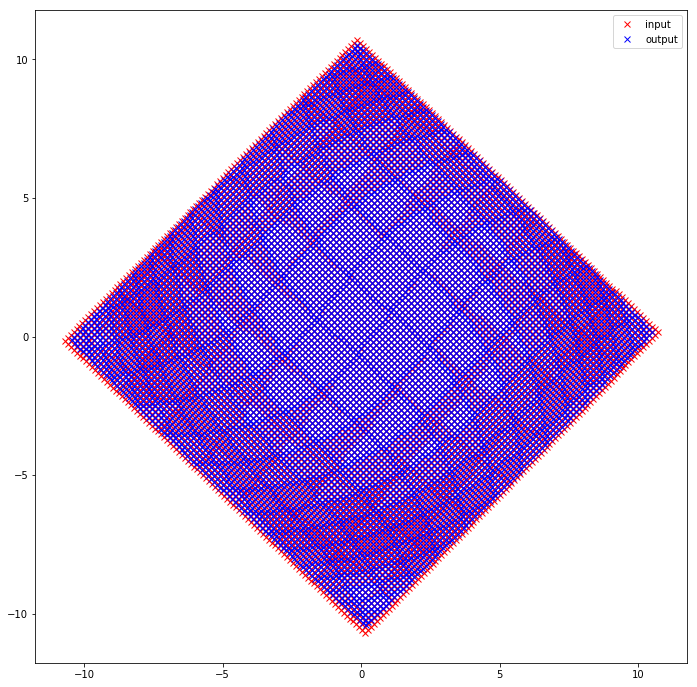

In [8]:
fig = plt.figure(figsize=(18,12))
ax= fig.add_subplot(111,aspect='equal')
ax.plot(xinput,yinput,'rx',label='input')
ax.plot(xoutput,youtput,'bx',label='output')

plt.legend()


# RMS error

In [9]:
np.sqrt((1./len(xinput))*np.sum((xinput-xoutput)**2+(yinput-youtput)**2))

0.071820532029905598

# Radial

In [10]:
def model(params,x_d,y_d,xinput,yinput):
    k = params[0]
    r_d = np.sqrt((x_d)**2 + (y_d)**2)
    r_u = r_d*(1+k*(r_d)**2)
    rinput = np.sqrt((xinput)**2 + (yinput)**2)
    return np.sum((r_u-rinput)**2)

In [11]:
x_d = xoutput
y_d = youtput
p0 = [2e-04]
mini = optimize.minimize(model, p0, args=(x_d,y_d,xinput,yinput))

In [12]:
print mini.x

[ 0.00019462]


In [13]:
x_d = xoutput; y_d = youtput; k = mini.x
r_d = np.sqrt((x_d)**2 + (y_d)**2)

x_u = x_d*(1+k*(r_d)**2)
y_u = y_d*(1+k*(r_d)**2)
print mini.x

[ 0.00019462]


In [14]:
d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-x_d)**2+(y_u-y_d)**2))
print 100*d_m_pixels

6.8953845209


# radial COD free param

In [21]:
def model(params,x_d,y_d,xinput,yinput):
    k = params[0]
    x_c = params[1]
    y_c = params[2]
    r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2)
    r_u = r_d*(1+k*(r_d)**2)
    rinput = np.sqrt((xinput-x_c)**2 + (yinput-y_c)**2)
    return np.sum((r_u-rinput)**2)

In [25]:
x_d = xoutput
y_d = youtput
p0 = [2e-04,0,0]
mini = optimize.minimize(model, p0, args=(x_d,y_d,xinput,yinput))

In [27]:
print  mini.x

[  1.90758007e-04   3.37599623e-01   8.94456165e-01]


In [28]:
x_d = xoutput; y_d = youtput
k = mini.x[0]; x_c = mini.x[1]; y_c = mini.x[2]
r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2)
x_u = x_d+(x_d-x_c)*k*(r_d)**2
y_u = y_d+(y_d-y_c)*k*(r_d)**2

In [29]:
d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-x_d)**2+(y_u-y_d)**2))
print 100*d_m_pixels

7.17108356434


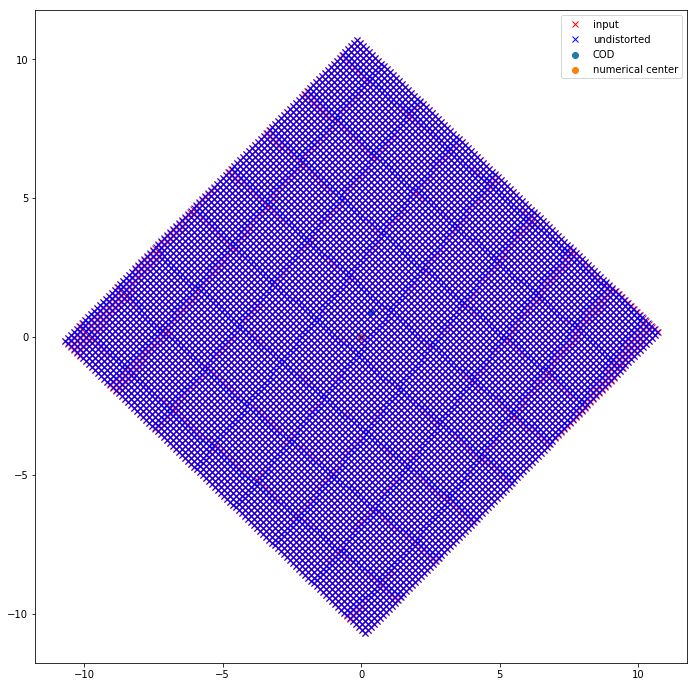

In [30]:
fig = plt.figure(figsize=(15,12))
ax= fig.add_subplot(111,aspect='equal')

ax.plot(xinput,yinput,'rx',label='input')
ax.plot(x_u,y_u,'bx',label='undistorted')
ax.scatter(mini.x[1], mini.x[2],label='COD')
ax.scatter(0,0,label='numerical center')


plt.legend()

# first and second order radial

In [44]:
def model(params,x_d,y_d,xinput, yinput):
     k1 = params[0]
     k2 = params[1]
     x_c = params[2]
     y_c = params[3]
     r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2)
     r_u = r_d*(1+k1*(r_d)**2+ k2*(r_d)**4)

     rinput = np.sqrt((xinput-x_c)**2 + (yinput-y_c)**2)
     return np.sum((r_u-rinput)**2)
     


In [45]:
x_d = xoutput
y_d = youtput
p0 = [2.4779678564e-4, 9e-2,0,0]
mini_x = optimize.minimize(model, p0, args=(x_d,y_d,xinput,yinput))

In [46]:
print mini_x.x

[  1.94403485e-04  -2.33785988e-09  -5.52033494e-03   2.19812582e-03]


In [48]:
x_d = xoutput; y_d = youtput; k1 = mini_x.x[0]; k2 = mini_x.x[1]
r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2 )

x_u = x_d+(x_d-x_c)*(k1*(r_d)**2 + k2*(r_d)**4)
y_u = y_d+(y_d-y_c)*(k1*(r_d)**2 + k2*(r_d)**4)

In [49]:
d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-x_d)**2+(y_u-y_d)**2))
print 100*d_m_pixels

7.3016328981


# Inverse model

In [55]:
def Inv_x(params,x_u,y_u,xoutput):
  k = params[0]
  x_c = params[1]
  y_c = params[2]
  r_u = np.sqrt((x_u-x_c)**2+(y_u-y_c)**2) 
  x_d = x_c+(x_u-x_c)*(1-k*r_u**2)
  return np.sum((x_d-xoutput)**2)   


def Inv_y(params,x_u,y_u,youtput):
  k = params[0]
  x_c = params[1]
  y_c = params[2]
  r_u = np.sqrt((x_u-x_c)**2+(y_u-y_c)**2) 
  y_d = y_c+(y_u-y_c)*(1-k*r_u**2)
  return np.sum((y_d-youtput)**2)   

def Inv_r(params,x_u,y_u,xoutput,youtput):
     k = params[0]
     x_c = params[1]
     y_c = params[2]
     r_u = np.sqrt((x_u-x_c)**2+(y_u-y_c)**2)
     r_d = r_u*(1-k*r_u**2)
     r_output = np.sqrt((xoutput-x_c)**2 + (youtput-y_c)**2)
     return np.sum((r_d-r_output)**2)

In [56]:
x_u = xinput
y_u = yinput
p0 = [1.8e-4,0,0]


mini_y = optimize.minimize(Inv_y, p0, args=(x_u,y_u,youtput))
mini_x = optimize.minimize(Inv_x, p0, args=(x_u,y_u,xoutput))
mini_r = optimize.minimize(Inv_r, p0, args=(x_u,y_u,xoutput,youtput))

In [57]:
print mini_y.x
print mini_x.x
print mini_r.x

[  1.79923412e-04   2.57528902e-01   9.80668276e-01]
[  1.84506895e-04   3.56615385e-01   5.88506048e-01]
[  1.83172506e-04   3.32780224e-01   8.81342298e-01]


# In order to test whether rotation affects the distortion coefficient, I apply the distortion model on the rotated points.


In [59]:
f = np.loadtxt(path+'Model_29')
i = f[:,0]; j = f[:,1]; xfield = f[:,2]; yfield = f[:,3]; R = f[:,4]; xinput = f[:,5]; yinput=f[:,6]; xoutput = f[:,7]; youtput = f[:,8]; distortion = f[:,9]

In [60]:
import math
x_r = 0; y_r =0
theta = math.radians(-45)
# input
x_p_in =  (xinput-x_r)* np.cos(theta) - (yinput-y_r) * np.sin(theta)
y_p_in = (xinput - x_r)* np.sin(theta) + (yinput- y_r) * np.cos(theta)
#output
x_p =  (xoutput-x_r)* np.cos(theta) - (youtput -y_r)* np.sin(theta)
y_p = (xoutput -x_r)* np.sin(theta) + (youtput -y_r)* np.cos(theta)


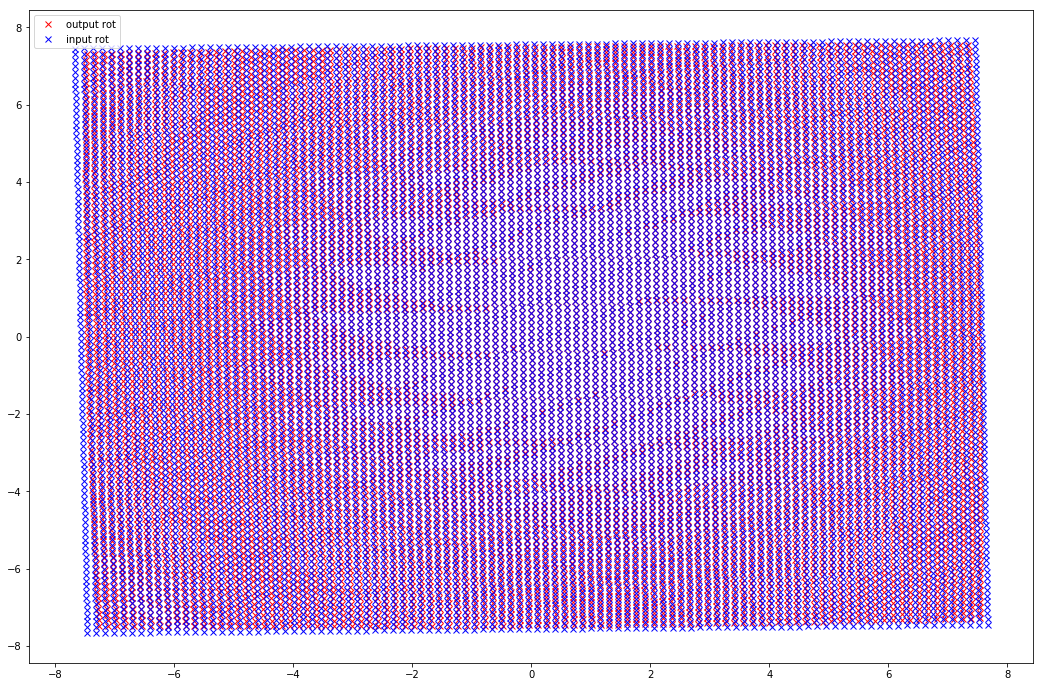

In [61]:

fig = plt.figure(figsize=(18,12))
plt.plot(x_p,y_p,'rx',label='output rot')
plt.plot(x_p_in,y_p_in,'bx',label='input rot')

plt.legend()


## RMS error


In [62]:
np.sqrt((1./len(x_p))*np.sum((x_p_in-x_p)**2+(y_p_in-y_p)**2))

0.071820532029905598

In [63]:
np.sqrt((1./len(xinput))*np.sum((xinput-xoutput)**2+(yinput-youtput)**2))

0.071820532029905598

In [64]:
def model(params,x_d,y_d,xinput,yinput):
    k = params[0]
    r_d = np.sqrt((x_d)**2 + (y_d)**2)
    r_u = r_d*(1+k*(r_d)**2)
    rinput = np.sqrt((xinput)**2 + (yinput)**2)
    return np.sum((r_u-rinput)**2)

In [65]:
x_d = x_p
y_d = y_p
p0 = [2e-04]
mini = optimize.minimize(model, p0, args=(x_d,y_d,x_p_in,y_p_in))

In [66]:
print mini.x

[ 0.00019462]


In [67]:
x_d = x_p; y_d = y_p
k = mini.x[0]; x_c = 0; y_c = 0
r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2)
x_u = x_d+(x_d-x_c)*k*(r_d)**2
y_u = y_d+(y_d-y_c)*k*(r_d)**2

In [68]:
d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-x_d)**2+(y_u-y_d)**2))
print 100*d_m_pixels

6.8953845209


# letting the COD a free param in the model

In [69]:
def model(params,x_d,y_d,xinput,yinput):
    k = params[0]
    x_c = params[1]
    y_c =params[2]
    r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2)
    r_u = r_d*(1+k*(r_d)**2)
    rinput = np.sqrt((xinput-x_c)**2 + (yinput-y_c)**2)
    return np.sum((r_u-rinput)**2)

In [70]:
x_d = x_p
y_d = y_p
p0 = [2e-04,0,0]
mini = optimize.minimize(model, p0, args=(x_d,y_d,x_p_in,y_p_in))

In [71]:
print mini.x
#[  1.90758007e-04   3.37599623e-01   8.94456165e-01]


[  1.90758009e-04   8.71194975e-01   3.93757027e-01]


In [70]:
x_d = x_p
y_d = y_p
x_c = mini.x[1]#0.539834083142#;
y_c =mini.x[2]#0.519991701946#
k =mini.x[0]#1.90871663e-04  #
r_d = np.sqrt((x_d-x_c)**2 + (y_d-y_c)**2)
x_u = x_d+(x_d-x_c)*k*(r_d)**2
y_u = y_d+(y_d-y_c)*k*(r_d)**2

In [89]:
d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-x_d)**2+(y_u-y_d)**2))
print 100*d_m_pixels

6.8953845209


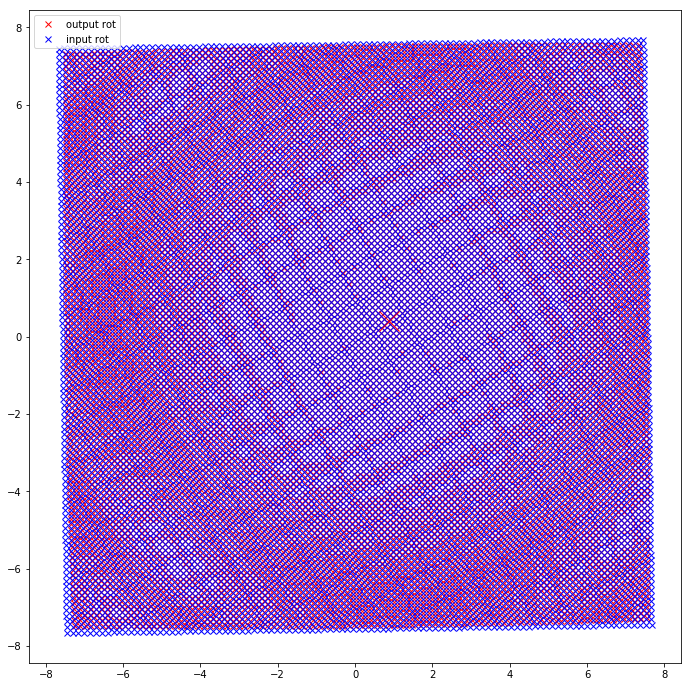

In [98]:
fig = plt.figure(figsize=(18,12))
ax= fig.add_subplot(111,aspect='equal')

ax.plot(x_p,y_p,'rx',label='output rot')
ax.plot(x_p_in,y_p_in,'bx',label='input rot')
ax.plot( mini.x[1], mini.x[2],'rx',markersize=20)

plt.legend()

# COD in the rotated frame

In [72]:
theta = math.radians(-45)
x_r = 0
y_r=0
xc = 3.37599623e-01
yc = 8.94456165e-01
x_c_r =  (xc-x_r)* np.cos(theta) - (yc -y_r)* np.sin(theta)
y_c_r = (xc -x_r)* np.sin(theta) + (yc -y_r)* np.cos(theta)

In [73]:
print x_c_r, y_c_r

0.871195002495 0.393757036996


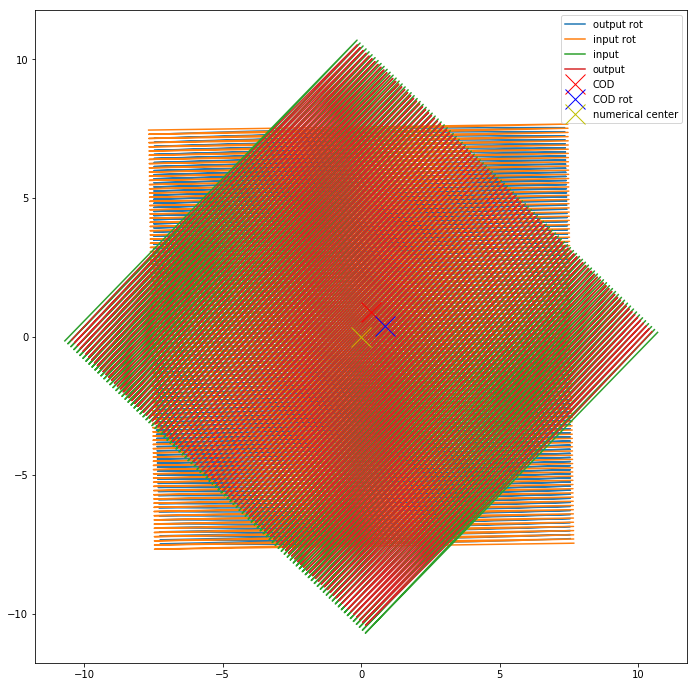

In [88]:
fig = plt.figure(figsize=(18,12))
ax= fig.add_subplot(111,aspect='equal')

ax.plot(x_p,y_p,label='output rot')
ax.plot(x_p_in,y_p_in,label='input rot')
ax.plot(xinput,yinput,label='input')
ax.plot(xoutput,youtput,label='output')
ax.plot(xc,yc,'rx',markersize=20,label='COD')
ax.plot(x_c_r,y_c_r,'bx',markersize=20,label='COD rot')
ax.plot(0,0,'yx',markersize=20,label='numerical center')
plt.legend()
